In [1]:
import cv2
import pandas as pd
import os
import shutil
import tensorflow as tf
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
(width, height) = (128, 128)
batch_size = 16

In [3]:
df = pd.read_csv("annotations.csv")

In [4]:
df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,maksssksksss0.png,512,366,without_mask,79,105,109,142
1,maksssksksss0.png,512,366,with_mask,185,100,226,144
2,maksssksksss0.png,512,366,without_mask,325,90,360,141
3,maksssksksss1.png,400,156,with_mask,321,34,354,69
4,maksssksksss1.png,400,156,with_mask,224,38,261,73
...,...,...,...,...,...,...,...,...
4067,maksssksksss98.png,400,267,with_mask,263,62,287,85
4068,maksssksksss98.png,400,267,with_mask,344,80,377,106
4069,maksssksksss99.png,400,267,mask_weared_incorrect,181,54,273,162
4070,maksssksksss99.png,400,267,with_mask,99,87,176,165


In [5]:
    # # Uncomment this section to save images in color

    # def save_cropped_image(index, row):
    #     img = cv2.imread(f"./Kaggle-MaskDetection/images/{row['filename']}")
    #     crop_img = img[row['ymin']:row['ymax'], row['xmin']:row['xmax']]
    #     resized_img = cv2.resize(crop_img, (width, height))
    #     if not os.path.exists(f"./Kaggle-MaskDetection/cropped/{row['class']}"):
    #         os.makedirs(f"./Kaggle-MaskDetection/cropped/{row['class']}")
    #     cv2.imwrite(f"./Kaggle-MaskDetection/cropped/{row['class']}/{index}-{row['filename']}", resized_img)

In [6]:
def save_cropped_image(index, row):
    img = cv2.imread(f"./Kaggle-MaskDetection/images/{row['filename']}")
    crop_img = img[row['ymin']:row['ymax'], row['xmin']:row['xmax']]
    grayImage = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
    resized_img = cv2.resize(grayImage, (width, height))
    if not os.path.exists(f"./Kaggle-MaskDetection/cropped/{row['class']}"):
        os.makedirs(f"./Kaggle-MaskDetection/cropped/{row['class']}")
    cv2.imwrite(f"./Kaggle-MaskDetection/cropped/{row['class']}/{index}-{row['filename']}", resized_img)

In [7]:
if os.path.exists('./Kaggle-MaskDetection/cropped'):
    shutil.rmtree('./Kaggle-MaskDetection/cropped')

if not os.path.exists('./Kaggle-MaskDetection/cropped'):
    os.makedirs('./Kaggle-MaskDetection/cropped')
    
for index, row in df.iterrows():
    save_cropped_image(index,row)

In [8]:
data_dir = f"./Kaggle-MaskDetection/cropped"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(width, height),
  batch_size=batch_size)


Found 4072 files belonging to 3 classes.
Using 3258 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(width, height),
  batch_size=batch_size)

Found 4072 files belonging to 3 classes.
Using 814 files for validation.


In [10]:
train_ds

<BatchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int32)>

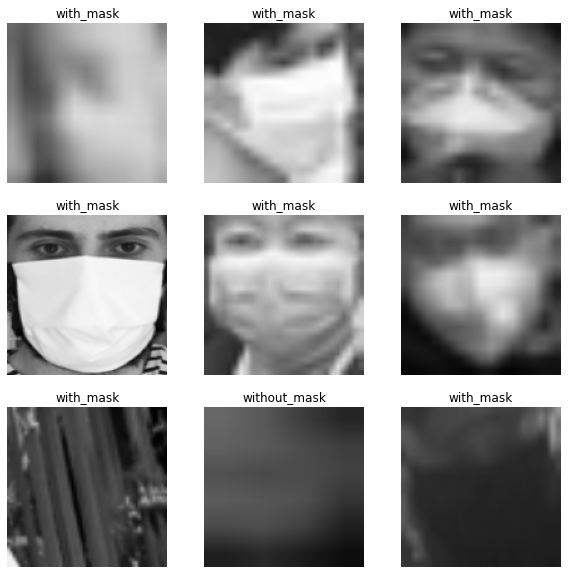

In [11]:
import matplotlib.pyplot as plt

class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(16, 128, 128, 3)
(16,)


In [13]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [14]:
normalization_layer

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.054901965 0.98823535


In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
num_classes = 3

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [18]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
204/204 [==============================] - 73s 353ms/step - loss: 0.5711 - accuracy: 0.7927 - val_loss: 0.4682 - val_accuracy: 0.7961
Epoch 2/10
204/204 [==============================] - 65s 318ms/step - loss: 0.4295 - accuracy: 0.8232 - val_loss: 0.3718 - val_accuracy: 0.8501
Epoch 3/10
204/204 [==============================] - 68s 334ms/step - loss: 0.3667 - accuracy: 0.8572 - val_loss: 0.4479 - val_accuracy: 0.8194
Epoch 4/10
204/204 [==============================] - 68s 331ms/step - loss: 0.3204 - accuracy: 0.8771 - val_loss: 0.3551 - val_accuracy: 0.8808
Epoch 5/10
204/204 [==============================] - 74s 361ms/step - loss: 0.2839 - accuracy: 0.8889 - val_loss: 0.3424 - val_accuracy: 0.8759
Epoch 6/10
204/204 [==============================] - 66s 326ms/step - loss: 0.2635 - accuracy: 0.8988 - val_loss: 0.3487 - val_accuracy: 0.8808
Epoch 7/10
204/204 [==============================] - 72s 355ms/step - loss: 0.2316 - accuracy: 0.9094 - val_loss: 0.3658 - val_ac

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy - Grayscale')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('./WhitePaperImages/Model Accuracy - Grayscale.png', dpi=500, transparent=False)
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss - Grayscale')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('./WhitePaperImages/Model Loss - Grayscale.png', dpi=500, transparent=False)
plt.show()